# Sweeps - Impedance, scattering and admittance (Z S Y) matrices

### Prerequisite
You need to have a working local installation of Ansys

## 1. Perform the necessary imports and create a QDesign in Metal first.

In [12]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [13]:
import qiskit_metal as metal
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings
import pyEPR as epr
from qiskit_metal.analyses.simulation import ScatteringImpedanceSim

## Create the design in Metal
 Set up a design of a given dimension.  Create a design by specifying the chip size and open Metal GUI.  Dimensions will be respected in the design rendering.  Note the chip design is centered at origin (0,0).

In [14]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '2mm'
design.chips.main.size['size_y'] = '2mm'

gui = MetalGUI(design)

# Perform the necessary imports.
from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee
from qiskit_metal.qlibrary.tlines.meandered import RouteMeander
from qiskit_metal.qlibrary.qubits.transmon_pocket import TransmonPocket
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

In [15]:
# To create plots after geting solution data.
import matplotlib.pyplot as plt
import numpy as np

In [16]:
# Add 2 transmons to the design.
options = dict(
    # Some options we want to modify from the deafults
    # (see below for defaults)
    pad_width='425 um',
    pocket_height='650um',
    # Adding 4 connectors (see below for defaults)
    connection_pads=dict(a=dict(loc_W=+1, loc_H=+1),
                         b=dict(loc_W=-1, loc_H=+1, pad_height='30um'),
                         c=dict(loc_W=+1, loc_H=-1, pad_width='200um'),
                         d=dict(loc_W=-1, loc_H=-1, pad_height='50um')))

## Create 2 transmons
q1 = TransmonPocket(design,
                    'Q1',
                    options=dict(pos_x='+1.4mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))
q2 = TransmonPocket(design,
                    'Q2',
                    options=dict(pos_x='-0.6mm',
                                 pos_y='0mm',
                                 orientation='90',
                                 **options))

gui.rebuild()
gui.autoscale()

In [17]:
# Add 2 hangers consisting of capacitively coupled transmission lines.
TQ1 = CoupledLineTee(design,
                     'TQ1',
                     options=dict(pos_x='1mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))
TQ2 = CoupledLineTee(design,
                     'TQ2',
                     options=dict(pos_x='-1mm',
                                  pos_y='3mm',
                                  coupling_length='500um',
                                  coupling_space='1um'))

gui.rebuild()
gui.autoscale()

In [18]:
# Add 2 meandered CPWs connecting the transmons to the hangers.
ops = dict(fillet='90um')
design.overwrite_enabled = True

options1 = Dict(total_length='8mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                               pin='second_end'),
                                end_pin=Dict(component='Q1', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

options2 = Dict(total_length='9mm',
                hfss_wire_bonds=True,
                pin_inputs=Dict(start_pin=Dict(component='TQ2',
                                               pin='second_end'),
                                end_pin=Dict(component='Q2', pin='a')),
                lead=Dict(start_straight='0.1mm'),
                **ops)

meanderQ1 = RouteMeander(design, 'meanderQ1', options=options1)
meanderQ2 = RouteMeander(design, 'meanderQ2', options=options2)

gui.rebuild()
gui.autoscale() 

In [19]:
# Add 2 open to grounds at the ends of the horizontal CPW.
otg1 = OpenToGround(design, 'otg1', options=dict(pos_x='3mm', pos_y='3mm'))
otg2 = OpenToGround(design,
                    'otg2',
                    options=dict(pos_x='-3mm', pos_y='3mm', orientation='180'))

gui.rebuild()
gui.autoscale()

# Add 3 straight CPWs that comprise the long horizontal CPW.

ops_oR = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ1', pin='prime_end'),
                              end_pin=Dict(component='otg1', pin='open')))
ops_mid = Dict(hfss_wire_bonds=True,
               pin_inputs=Dict(start_pin=Dict(component='TQ1',
                                              pin='prime_start'),
                               end_pin=Dict(component='TQ2', pin='prime_end')))
ops_oL = Dict(hfss_wire_bonds=True,
              pin_inputs=Dict(start_pin=Dict(component='TQ2',
                                             pin='prime_start'),
                              end_pin=Dict(component='otg2', pin='open')))

cpw_openRight = RouteStraight(design, 'cpw_openRight', options=ops_oR)
cpw_middle = RouteStraight(design, 'cpw_middle', options=ops_mid)
cpw_openLeft = RouteStraight(design, 'cpw_openLeft', options=ops_oL)

gui.rebuild()
gui.autoscale()

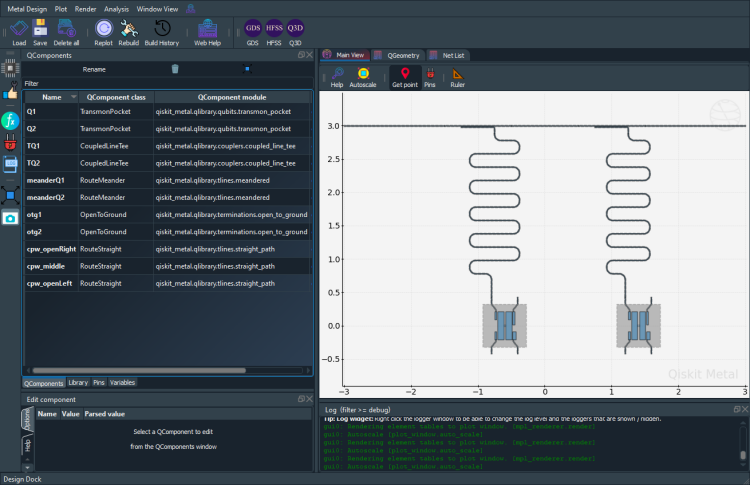

In [20]:
gui.screenshot()

## 2. Render the qubit from Metal into the HangingResonators design in Ansys. <br>ScatteringImpedanceSim will  open the simulation software. Then will connect, activate the design, add a setup.  

Review and update the setup. For driven modal you will need to define not only the simulation convergence parameters, but also the frequency sweep.




In [21]:
em1 = ScatteringImpedanceSim(design, "hfss")

Customizable parameters and default values for HFSS (driven  modal):

    freq_ghz=5 (simulation frequency)
    name="Setup" (setup name)
    max_delta_s=0.1 (absolute value of maximum difference in scattering parameter S)
    max_passes=10 (maximum number of passes)
    min_passes=1 (minimum number of passes)
    min_converged=1 (minimum number of converged passes)
    pct_refinement=30 (percent refinement)
    basis_order=1 (basis order)
    vars (global variables to set in the renderer)
    sweep_setup (all the parameters of the sweep)
    name="Sweep" (name of sweep)
    start_ghz=2.0 (starting frequency)
    stop_ghz=8.0 (stopping frequency)
    count=101 (total number of frequencies)
    step_ghz=None (frequency step size)
    type="Fast" (type of sweep)
    save_fields=False (whether or not to save fields)

In [22]:
# To view the values for defaults. 
em1.setup

{'name': 'Setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 5,
 'max_delta_s': 0.1,
 'max_passes': 10,
 'min_passes': 1,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep',
  'start_ghz': 2.0,
  'stop_ghz': 8.0,
  'count': 101,
  'step_ghz': None,
  'type': 'Fast',
  'save_fields': False}}

In [23]:
em1.setup.name = "Sweep_DrivenModal_setup"
em1.setup.freq_ghz = 6.0
em1.setup.max_delta_s = 0.05
em1.setup.max_passes = 12
em1.setup.min_passes = 2


Add a frequency sweep to a driven modal setup.<br>
From QHFSSRenderer.add_sweep doc_strings.  Please go to doc_strings to get the latest information.  

Args:<br>
    setup_name (str, optional): Name of driven modal simulation Sweep.
                            Defaults to "Setup".<br>
    start_ghz (float, optional): Starting frequency of sweep in GHz.
                            Defaults to 2.0.<br>
    stop_ghz (float, optional): Ending frequency of sweep in GHz.
                            Defaults to 8.0.<br>
    count (int, optional): Total number of frequencies.
                            Defaults to 101.<br>
    step_ghz (float, optional): Difference between adjacent
                            frequencies. Defaults to None.<br>
    name (str, optional): Name of sweep. Defaults to "Sweep".<br>
    type (str, optional): Type of sweep. Defaults to "Fast".<br>
    save_fields (bool, optional): Whether or not to save fields.
                        Defaults to False.<br>
                        
                        
From pyEPR.HfssSetup.insert_sweep(), please go to this method to get the latest documentation.   
You should provide either step_ghz or count when inserting an HFSS driven model freq sweep. Do not provide both or neither!

In [24]:
# To view the values for defaults. 
em1.setup.sweep_setup

{'name': 'Sweep',
 'start_ghz': 2.0,
 'stop_ghz': 8.0,
 'count': 101,
 'step_ghz': None,
 'type': 'Fast',
 'save_fields': False}

In [25]:
em1.setup.sweep_setup.name="Sweep_options__dm_sweep"
em1.setup.sweep_setup.start_ghz=4.0
em1.setup.sweep_setup.stop_ghz=9.0
em1.setup.sweep_setup.count=5001
em1.setup.sweep_setup.type="Interpolating"


em1.setup

{'name': 'Sweep_DrivenModal_setup',
 'reuse_selected_design': True,
 'reuse_setup': True,
 'freq_ghz': 6.0,
 'max_delta_s': 0.05,
 'max_passes': 12,
 'min_passes': 2,
 'min_converged': 1,
 'pct_refinement': 30,
 'basis_order': 1,
 'vars': {'Lj': '10 nH', 'Cj': '0 fF'},
 'sweep_setup': {'name': 'Sweep_options__dm_sweep',
  'start_ghz': 4.0,
  'stop_ghz': 9.0,
  'count': 5001,
  'step_ghz': None,
  'type': 'Interpolating',
  'save_fields': False}}

In [26]:
# Set the buffer width at the edge of the design to be 0.5 mm 
# in both directions.
em1.setup.renderer.options['x_buffer_width_mm'] = 0.5
em1.setup.renderer.options['y_buffer_width_mm'] = 0.5

In [27]:
#     qcomp_name (str): A component that contains the option to be swept.
#     option_name (str): The option within qcomp_name to sweep.
#     option_sweep (list): Each entry in the list is a value for
#                 option_name.
#     qcomp_render (list): The component to render to simulation.
#     open_terminations (list): Identify which kind of pins. Follow the
#                 details from renderer QQ3DRenderer.render_design, or
#                 QHFSSRenderer.render_design.
#     port_list (list): List of tuples of jj's that shouldn't
#                     be rendered.  Follow details from
#                     renderer in QHFSSRenderer.render_design.
#     jj_to_port (list): List of junctions (qcomp, qgeometry_name,
#                         impedance, draw_ind) to render as lumped ports
#                         or as lumped port in parallel with a sheet
#                         inductance.    Follow details from renderer
#                         in QHFSSRenderer.render_design.
#     ignored_jjs (Union[list,None]): This is not used by all renderers,
#                  just hfss.
#     design_name(str): Name of design (workspace) to use in project.
#     box_plus_buffer(bool): Render the entire chip or create a
#                 box_plus_buffer around the components which are rendered.


In [28]:

design_name= "Sweep_DrivenModal"
qcomp_render = [] # Means to render everything in qgeometry table.
open_terminations = []

# Here, pin cpw_openRight_end and cpw_openLeft_end are converted into lumped ports,
#           each with an impedance of 50 Ohms. <br>
port_list = [('cpw_openRight', 'end', 50),
                      ('cpw_openLeft', 'end', 50)]
jj_to_port = [('Q1', 'rect_jj', 50, False)]
# Neither of the junctions in Q1 or Q2 are rendered.
ignored_jjs = [('Q2', 'rect_jj')]
box_plus_buffer = True

In [29]:
#Note: The method will connect to  Ansys simulation, activate_drivenmodal_design(), add_drivenmodal_setup().

all_sweeps, return_code = em1.run_sweep(meanderQ1.name,
                                        'total_length', 
                                        ['9mm', '10mm', '11mm'],
                                        qcomp_render,
                                        open_terminations,
                                        design_name=design_name,
                                        port_list = port_list,
                                        jj_to_port= jj_to_port,
                                        ignored_jjs= ignored_jjs,
                                        box_plus_buffer=box_plus_buffer
                                       )

INFO 05:26PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:26PM [load_ansys_project]: 	Opened Ansys App
INFO 05:26PM [load_ansys_project]: 	Opened Ansys Desktop v2021.1.0
INFO 05:26PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    D:/lfl/Documents/Ansoft/
	Project:   Project25
INFO 05:26PM [connect_design]: 	Opened active design
	Design:    Sweep_DrivenModal_hfss [Solution type: DrivenModal]
INFO 05:26PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 05:26PM [connect]: 	Connected to project "Project25" and design "Sweep_DrivenModal_hfss" 😀 

INFO 05:26PM [connect_design]: 	Opened active design
	Design:    Sweep_DrivenModal_hfss [Solution type: DrivenModal]
INFO 05:27PM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 05:27PM [get_setup]: 	Opened setup `Sweep_DrivenModal_setup`  (<class 'pyEPR.ansys.HfssDMSetup'>)
INFO 05:27PM [analyze]: Analyzing setup Sweep_DrivenModal_setup : Sweep_op

#Note: Sweep again using the arguments from previous run.  
```
all_sweeps_6_7_8, return_code = em1.run_sweep(meanderQ1.name,
                                        'total_length', 
                                        ['6.5mm', '7.5mm', '8.5mm']
                                       )
```

In [30]:

if return_code == 0:
    # Each key corresponds to list passed to ['9mm', '8mm', '7mm']
    print(all_sweeps.keys())
    
    # Each key corresponds to list passed to ['6mm', '5mm', '4mm']
    # print(all_sweeps_6_7_8.keys())
else:
    print('Check warning messages to see why all_sweeps is non-zero.')


dict_keys(['9mm', '10mm', '11mm'])


In [31]:
all_sweeps['9mm'].keys()

dict_keys(['option_name', 'variables'])

05:36PM 45s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [32]:
all_sweeps['9mm']['variables']

{'sim_setup_name': 'Sweep_DrivenModal_setup',
 'sweep_name': 'Sweep_options__dm_sweep'}

In [33]:
all_sweeps['9mm']['option_name']


'total_length'

05:36PM 45s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [34]:
print(f"""
project_name = {em1.renderer.pinfo.project_name}
design_name  = {em1.renderer.pinfo.design_name}
setup_name   = {em1.renderer.pinfo.setup_name}
""")


project_name = Project25
design_name  = Sweep_DrivenModal_hfss
setup_name   = Sweep_DrivenModal_setup



Note: Results storage is currently being updated to be fully functional with the sweep functionality.

In [35]:
em1.get_impedance()                # default: ['Z11', 'Z21']

(                        Z11                   Z21
 4.000   0.000000-11.785487j   0.000000+45.345454j
 4.001  -0.000001-11.770034j  -0.000000+45.341317j
 4.002  -0.000001-11.754582j  -0.000000+45.337184j
 4.003  -0.000002-11.739134j  -0.000000+45.333057j
 4.004  -0.000003-11.723687j  -0.000000+45.328936j
 ...                     ...                   ...
 8.996  0.004065+196.717784j  0.005096+198.550566j
 8.997  0.003126+197.014078j  0.003921+198.836266j
 8.998  0.002136+197.311173j  0.002682+199.122768j
 8.999  0.001095+197.609071j  0.001376+199.410074j
 9.000 -0.000000+197.907772j -0.000000+199.698186j
 
 [5001 rows x 2 columns],
 <Figure size 1000x600 with 2 Axes>)

05:36PM 47s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [36]:
em1.get_admittance()              # default: ['Y11', 'Y21']

(                      Y11                 Y21
 4.000  0.000000-0.006809j -0.000000-0.023823j
 4.001 -0.000000-0.006802j -0.000000-0.023821j
 4.002 -0.000000-0.006794j -0.000000-0.023818j
 4.003 -0.000000-0.006786j -0.000000-0.023816j
 4.004 -0.000000-0.006778j -0.000000-0.023814j
 ...                   ...                 ...
 8.996 -0.000007+0.093233j  0.000007-0.097409j
 8.997 -0.000005+0.093372j  0.000006-0.097546j
 8.998 -0.000004+0.093512j  0.000004-0.097683j
 8.999 -0.000002+0.093652j  0.000002-0.097821j
 9.000 -0.000000+0.093793j  0.000000-0.097959j
 
 [5001 rows x 2 columns],
 <Figure size 1000x600 with 2 Axes>)

In [37]:
em1.get_scattering(['S11', 'S21', 'S31'])          ## default: ['S11', 'S21', 'S22']

(                      S11                 S21                 S31
 4.000 -0.129036-0.022905j -0.268185+0.954412j -0.000155-0.000083j
 4.001 -0.129056-0.022862j -0.267877+0.954497j -0.000156-0.000083j
 4.002 -0.129075-0.022818j -0.267570+0.954581j -0.000157-0.000084j
 4.003 -0.129095-0.022775j -0.267263+0.954666j -0.000157-0.000084j
 4.004 -0.129114-0.022732j -0.266955+0.954750j -0.000158-0.000084j
 ...                   ...                 ...                 ...
 8.996  0.011046+0.026470j  0.973153+0.228385j -0.000308+0.000332j
 8.997  0.011058+0.026428j  0.973229+0.228061j -0.000308+0.000331j
 8.998  0.011069+0.026387j  0.973305+0.227736j -0.000307+0.000331j
 8.999  0.011081+0.026345j  0.973380+0.227411j -0.000307+0.000331j
 9.000  0.011093+0.026304j  0.973456+0.227087j -0.000307+0.000331j
 
 [5001 rows x 3 columns],
 <Figure size 1000x600 with 2 Axes>)

05:36PM 49s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [38]:
dataframe_scattering = em1.get_scattering(['S11', 'S21', 'S31'])
df_s = dataframe_scattering[0]

In [39]:
df_s.to_csv("df_s.csv")

05:36PM 50s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [40]:
dataframe_scattering[1]
plt.show()

In [41]:
s11 = df_s['S11']
s11

s21 = df_s['S21']
s21

s31 = df_s['S31']
s31

4.000   -0.000155-0.000083j
4.001   -0.000156-0.000083j
4.002   -0.000157-0.000084j
4.003   -0.000157-0.000084j
4.004   -0.000158-0.000084j
                ...        
8.996   -0.000308+0.000332j
8.997   -0.000308+0.000331j
8.998   -0.000307+0.000331j
8.999   -0.000307+0.000331j
9.000   -0.000307+0.000331j
Name: S31, Length: 5001, dtype: complex128

05:36PM 50s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [42]:
dataframe_scattering[0]['20_log_of_mag_S11']= 20 * np.log10(np.absolute(s11))
dataframe_scattering[0]['20_log_of_mag_S21']= 20 * np.log10(np.absolute(s21))
dataframe_scattering[0]['20_log_of_mag_S31']= 20 * np.log10(np.absolute(s31))
dataframe_scattering[0]

,S11,S21,S31,20_log_of_mag_S11,20_log_of_mag_S21,20_log_of_mag_S31
4.000,-0.129036-0.022905j,-0.268185+0.954412j,-0.000155-0.000083j,-17.651018,-0.075238,-75.080863
4.001,-0.129056-0.022862j,-0.267877+0.954497j,-0.000156-0.000083j,-17.650252,-0.075252,-75.046602
4.002,-0.129075-0.022818j,-0.267570+0.954581j,-0.000157-0.000084j,-17.649487,-0.075265,-75.012236
4.003,-0.129095-0.022775j,-0.267263+0.954666j,-0.000157-0.000084j,-17.648722,-0.075278,-74.977763
4.004,-0.129114-0.022732j,-0.266955+0.954750j,-0.000158-0.000084j,-17.647959,-0.075291,-74.943182
...,...,...,...,...,...,...
8.996,0.011046+0.026470j,0.973153+0.228385j,-0.000308+0.000332j,-30.847615,-0.003534,-66.882240
8.997,0.011058+0.026428j,0.973229+0.228061j,-0.000308+0.000331j,-30.857924,-0.003535,-66.891359
8.998,0.011069+0.026387j,0.973305+0.227736j,-0.000307+0.000331j,-30.868227,-0.003537,-66.900457
8.999,0.011081+0.026345j,0.973380+0.227411j,-0.000307+0.000331j,-30.878522,-0.003539,-66.909534


In [43]:
# Reference to current axis. 
magnitude = plt.figure('Magnitude S11, S21, and S31')
plt.clf()
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S11', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S21', color = 'blue', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='20_log_of_mag_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Magnitude')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'|S11|,|S21|,|S31| [dB]')
magnitude.show()

05:36PM 51s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [44]:
# Data is shown as degrees.  
# However, if you want radians, change value of deg to false, deg=False.
dataframe_scattering[0]['degrees_S11'] = np.angle(s11, deg=True)
dataframe_scattering[0]['degrees_S21'] = np.angle(s21, deg=True)
dataframe_scattering[0]['degrees_S31'] = np.angle(s31, deg=True)
dataframe_scattering[0]

,S11,S21,S31,20_log_of_mag_S11,20_log_of_mag_S21,20_log_of_mag_S31,degrees_S11,degrees_S21,degrees_S31
4.000,-0.129036-0.022905j,-0.268185+0.954412j,-0.000155-0.000083j,-17.651018,-0.075238,-75.080863,-169.934238,105.695093,-151.877316
4.001,-0.129056-0.022862j,-0.267877+0.954497j,-0.000156-0.000083j,-17.650252,-0.075252,-75.046602,-169.954419,105.676664,-151.892282
4.002,-0.129075-0.022818j,-0.267570+0.954581j,-0.000157-0.000084j,-17.649487,-0.075265,-75.012236,-169.974600,105.658236,-151.907249
4.003,-0.129095-0.022775j,-0.267263+0.954666j,-0.000157-0.000084j,-17.648722,-0.075278,-74.977763,-169.994784,105.639807,-151.922216
4.004,-0.129114-0.022732j,-0.266955+0.954750j,-0.000158-0.000084j,-17.647959,-0.075291,-74.943182,-170.014968,105.621378,-151.937183
...,...,...,...,...,...,...,...,...,...
8.996,0.011046+0.026470j,0.973153+0.228385j,-0.000308+0.000332j,-30.847615,-0.003534,-66.882240,67.348506,13.207483,132.915161
8.997,0.011058+0.026428j,0.973229+0.228061j,-0.000308+0.000331j,-30.857924,-0.003535,-66.891359,67.295087,13.188383,132.899180
8.998,0.011069+0.026387j,0.973305+0.227736j,-0.000307+0.000331j,-30.868227,-0.003537,-66.900457,67.241562,13.169280,132.883191
8.999,0.011081+0.026345j,0.973380+0.227411j,-0.000307+0.000331j,-30.878522,-0.003539,-66.909534,67.187927,13.150175,132.867194


In [45]:
# Reference to current axis. 
phase = plt.figure('Phase of S11 and S21')
plt.clf()
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='degrees_S11', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='degrees_S21', color = 'blue', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='degrees_S31', color = 'red', ax = axis)
plt.title(f'S-Parameter Phase')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f'<S11, <S21, <S31 [degrees]')
phase.show()

05:36PM 51s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [46]:
em1.close()

In [47]:
# Uncomment next line if you would like to close the gui
# gui.main_window.close()

05:36PM 52s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



# Analysis to Get Kappa

In [48]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
!pip install ../.

Processing c:\users\lfl\metal-library
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for metal-library: filename=metal_library-1.0.0-py3-none-any.whl size=572898 sha256=ce568b66a5ca0a3964c7f830d2f666d7080743400d5bbf7569a865ccf7a7e8e3
  Stored in directory: c:\users\lfl\appdata\local\pip\cache\wheels\a7\4a\9c\0cfe2ec6c6be710a3e8d71b6156e1c76406fee205810faaa9d
Successfully built metal-library
  Attempting uninstall: metal-library
    Found existing installation: metal-library 1.0.0
    Uninstalling metal-library-1.0.0:
      Successfully uninstalled metal-library-1.0.0


05:36PM 57s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [50]:
import pandas as pd
import matplotlib.pyplot as plt

In [51]:
from metal_library.utils.fitTools import Resonator

05:36PM 57s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [52]:
def get_real_and_imag(a_ii):
    return a_ii.values.real, a_ii.values.imag

s21real, s21imag = get_real_and_imag(df_s['S21'])
#y11real, y11imag = get_real_and_imag(df_y['Y11'])


dataframe_scattering[0]['Real(S21)'] = s21real
dataframe_scattering[0]['Imag(S21)'] = s21imag

In [53]:
# Reference to current axis.
magnitude = plt.figure('Real S21, Imag S21')
axis = plt.gca() # Get current axis.
dataframe_scattering[0].plot(kind = 'line', y='Real(S21)', color = 'green', ax = axis)
dataframe_scattering[0].plot(kind = 'line', y='Imag(S21)', color = 'blue', ax = axis)
plt.title(f'S-Parameter Amplitude')
plt.xlabel(f'frequency [GHZ]')
plt.ylabel(f're(S22), im(S22) Amp')
magnitude.show()

05:36PM 58s CRITICAL [_qt_message_handler]: line: 0, func: None(), file: None  CRITICAL: QEventDispatcherWin32::wakeUp: Failed to post a message (Not enough quota is available to process this command.)



In [54]:
reals21 = dataframe_scattering[0]['Real(S21)']
imags21 = dataframe_scattering[0]['Imag(S21)']
freqs = np.array(list(reals21.keys())) * 1e9
I = np.array(list(reals21.values))
Q = np.array(list(imags21.values))

In [61]:
%matplotlib inline

In [82]:
import pandas as pd

# Load the CSV file into a DataFrame
df = pd.read_csv("path/to/your/freqs_I_Q.csv")

# Extract the columns into variables
freqs = df['freqs'].to_numpy()
I = df['I'].to_numpy()
Q = df['Q'].to_numpy()


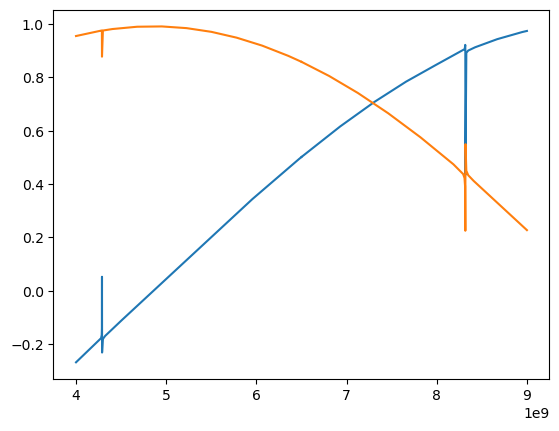

In [63]:
plt.plot(freqs,I)
plt.plot(freqs,Q)
plt.show()

In [71]:
llim, ulim = 100,500

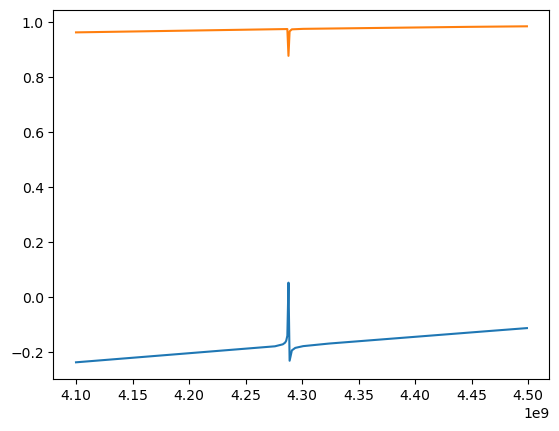

In [72]:
plt.plot(freqs[llim:ulim],I[llim:ulim])
plt.plot(freqs[llim:ulim],Q[llim:ulim])
plt.show()

In [79]:
res = Resonator(f_data=freqs[llim:ulim],z_data=I[llim:ulim] + 1j*Q[llim:ulim])


In [80]:
res.autofit()

AttributeError: module 'numpy' has no attribute 'int'.
`np.int` was a deprecated alias for the builtin `int`. To avoid this error in existing code, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
The aliases was originally deprecated in NumPy 1.20; for more details and guidance see the original release note at:
    https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

In [78]:
# -*- coding: utf-8 -*-
"""
A resonator object which fits complex scattering data to the model for direct reflection, direct transmission, or notch
type resonators. If desired, one can use high snr data to first calibrate the overall environmental effects such as phase delay and rotation with resonator.add_calibration_data(f_data,z_data). Subsequent data added with resonator.new_data(f_data,z_data) will be normalized by the overall calibration found previously.

The circlefit method is adapted from Probst et al. 'Efficient and robust analysis of complex scattering data under noise in microwave resonators' (2015)

"""

from metal_library.utils.fitTools.utilities import plotting, save_load, Watt2dBm, dBm2Watt
from metal_library.utils.fitTools.circlefit import circlefit
from metal_library.utils.fitTools.calibration import calibration

from scipy.constants import hbar
from scipy.signal import savgol_filter
import numpy as np 
import warnings
import scipy.optimize as spopt

##
## z_data_raw denotes the raw data
## z_data denotes the normalized data
##

class Resonator(circlefit, save_load, plotting, calibration):
    
    def __init__(self,port_type='reflection',f_data=None, z_data=None):
        '''A resonator fitting object. port_type must be a string identifying the type
        of resonator geometry as "reflection", "transmission", or "notch"
        '''
        if type(port_type) is not str:
            print('WARNING: port_type provided was not a string. Assuming a reflection geometry.')
            self.port_type = 'R'
        else:
            if port_type.lower()[0] == 'r':
                self.port_type = 'R'
            elif port_type.lower()[0] == 't':
                self.port_type = 'T'
            elif port_type.lower()[0] == 'n':
                self.port_type = 'N'
            else:
                print('WARNING: port_type provided could not be understood. Assuming a reflection geometry.')
                self.port_type = 'R'
        self.z_data = None
        self.calibration_data = None
        if f_data is not None:
            self.f_data = np.array(f_data)
        else:
            self.f_data = None
        if z_data is not None:
            self.z_data_raw = np.array(z_data)
        else:
            self.z_data_raw = None
            
        # define parameters as nans, update with fit results later
        self.f0 = np.nan
        self.Q = np.nan
        self.Qi = np.nan
        self.Qc = np.nan
        self.absQc = np.nan
        self.kappa = np.nan
        self.snr = np.nan
        self.diameter = np.nan
        self.delay = np.nan
        self.ringdown_time = np.nan
        self.theta0 = np.nan
        self.offrespoint = np.nan
        self.alpha = np.nan
        self.amp = np.nan
        self.phi0 = np.nan
        self.Q_est = np.nan
        self.f0_est = np.nan
        self.P1photon = np.nan
        self.amp_trans = np.nan
        
        self.fit_found = False
        self.calibrated = False
        self.normalized = False
        
    def autofit(self,electric_delay=None,fcrop=None,force_calibrate=False):
        '''
        automatic normalization and fitting.
        electric_delay: set the electric delay manually, not recommended.
        fcrop = (f1,f2) in GHz: crop the frequency range used for fitting.
        calibration of environment effects will be performed if it has not yet been 
        done or it is forced with the force_calibrate option.
        '''
        if fcrop is None:
            self._fid = np.ones(self.f_data.size,dtype=bool)
        else:
            f1, f2 = np.array(fcrop) * 1e9
            self._fid = np.logical_and(self.f_data>=f1,self.f_data<=f2)
        
        # There is no extra information to be gained by circlefit or phase fit for transmission resonators,
        # so the fit methods are different. Handle notch and resonators first
        if self.port_type is not 'T':
            if force_calibrate or not self.calibrated:
                self.do_calibration(ignore_slope=True,guess_delay=True,
                                    fixed_delay=electric_delay,force_calibrate=force_calibrate)
            
            # perform the canonical normalization that rotates the off resonant point to the real axis at +- 1. 
            self.do_normalization()
        
            # run circlefit with the (possibly) cropped, canonically normalized data. 
            # self.f0_est and self.Q_est used as initial guesses for phasefit
            self.circlefit(refine_results=False,calc_errors=True)
        else:
            self.fit_transmission()
        
        # generate the fitted model data
        if self.fit_found:
            if self.port_type is 'R':
                self.z_data_sim = self._S11_directrefl(self.f_data,fr=self.f0,Ql=self.Q,Qc=self.Qc,
                                                       a=self.amp,alpha=self.alpha,delay=self.delay)
                self.z_data_sim_norm = self._S11_directrefl(self.f_data,fr=self.f0,Ql=self.Q,Qc=self.Qc,
                                                            a=1.,alpha=0.,delay=0.)
            elif self.port_type is 'N':
                self.z_data_sim = self._S21_notch(self.f_data,fr=self.f0,Ql=self.Q,Qc=self.absQc,phi=self.phi0,
                                                  a=self.amp,alpha=self.alpha,delay=self.delay)
                self.z_data_sim_norm = self._S21_notch(self.f_data,fr=self.f0,Ql=self.Q,Qc=self.absQc,phi=self.phi0,
                                                            a=1.,alpha=0.,delay=0.)
            elif self.port_type is 'T':
                self.z_data_sim = self._S21_direct(self.f_data,fr=self.f0,Ql=self.Q,A=self.amp_trans,alpha=self.alpha,
                                               delay=self.delay)
                self.z_data_sim_norm = self._S21_direct(self.f_data,fr=self.f0,Ql=self.Q,A=self.amp_trans,alpha=0,delay=0)
                
            self.snr = self.get_snr()
        else:
            print('The fit could not be found, try cropping the data with autofit(fcrop=(f1 [GHz],f2 [GHz]))')
        
    def do_calibration(self,ignore_slope=True,guess_delay=True,fixed_delay=None,force_calibrate=False):
        '''
        performs an automated calibration and tries to determine the prefactors a, alpha, delay
        fr, Ql, and a possible slope are extra information, which can be used as start parameters for subsequent fits
        see also "do_normalization"
        the calibration procedure works for transmission line resonators as well
        '''
        # if no calibration data is present or the force_calibrate option is given, then use the current dataset
        if force_calibrate or self.calibration_data is None:
            z_data = self.z_data_raw[self._fid]
            f_data = self.f_data[self._fid]
        else:
            z_data = self.calibration_data['z']
            f_data = self.calibration_data['f']
        
        # normalize the complex z data by it's max magnitude
        #maxval = np.max(np.absolute(z_data))
        #z_data_temp = z_data/maxval
        
        # fit the electrical delay in the data, unless the delay is provided already.
        #if type(fixed_delay) not in (int,float,np.float32,np.float64,np.int):
        #    if guess_delay == True:
        #        delay = self._guess_delay(f_data,z_data_temp)
        #    else:
        #        delay=0.
        #    self.delay = self._fit_delay(f_data,z_data_temp,delay,maxiter=200)
        #else:
        #    self.delay = fixed_delay

        self.delay,params = self.get_delay(f_data,z_data,ignoreslope=ignore_slope,guess=guess_delay,delay=fixed_delay)
            
        # remove electrical delay
        z_data *= np.exp(2j*np.pi*self.delay*f_data)
        
        # fit the circle in complex plane
        xc, yc, r0 = self._fit_circle(z_data)
        zc = complex(xc,yc)
        
        # center the circle at the complex origin
        z_data_center = self._center(z_data,zc)
        
        # smooth the phase of centered data
        #window = round(len(z_data)*0.01)  # Average over 1% of the range
        #if (window % 2 == 0):
        #    window += 1       # ensure the window has an odd number of points
        #window = max(window, 11)
        #phase_smoothed = savgol_filter(np.angle(z_data_center), window, 3)
        # plot for debugging purposes
        #import matplotlib.pyplot as plt
        #plt.plot(f_data,phase_smoothed)
        #plt.show()
        
        # estimate the resonant frequency by taking the gradient of phase. 
        # this estimation method is robust to arbitrary phase offset and branch cuts.
        #phase_data = np.angle(z_data_center)
        #grad = np.abs(np.gradient(np.sin(phase_data)))
        #fr_ind = np.argmax(grad)
        #f0_est = f_data[fr_ind]
        #print('gradient estimate of f0: {:.3f} GHz'.format(f0_est*1e-9))
        #plt.plot(f_data,grad)
        #plt.show()
        
        # estimate the bandwidth with gradient of phase at resonance
        #slope = np.gradient(phase_data)[fr_ind]
        #Q_est = abs(slope*f0_est/(1000*np.pi))
        #print('Q_est = {:.1f}'.format(Q_est))
        #bw_ind = np.logical_and(phase_data < (phase_data[fr_ind]+np.pi/2),
        #                        phase_data > (phase_data[fr_ind]-np.pi/2))
        #bw = f_data[bw_ind]
        #Q_est = 2*np.pi*f0_est/(bw[-1]-bw[0])
        #print('Q_est is {}'.format(Q_est))
        
        # estimate the bandwidth from gradient method used above.
        #res_id = grad_tan > 1
        #if not res_id.any():
        #    print('bandwidth estimation failed. Using a standard guess of 30 elements.')
        #    start = max(0,fr_ind-15)
        #    stop = min(len(res_id),fr_ind+15)
        #    res_id[start:stop] = True
        #res_f = f_data[res_id]
        #Q_est = f_data[fr_ind]/(res_f[-1]-res_f[0])
        

        # fit the phase of centered circle. theta is the phase offset
        #print('pre-estimates are f0: {}, Q: {}'.format(f0_est,Q_est))
        theta, self.Q_est, self.f0_est = self._phase_fit(f_data,z_data_center,0,np.absolute(params[5]),params[4])
        
        # beta is the negative supplement of theta, it is the angle of the offresonant point relative to center of circle.
        beta = self._periodic_boundary(theta+np.pi,np.pi)
        
        # construct the off resonant point from circle center/radius and angle beta
        self.offrespoint = complex((xc+r0*np.cos(beta)),(yc+r0*np.sin(beta)))
        
        # alpha is the phase of offresonant point. it's the angle you must rotate the data so off resonance is purely real.
        self.alpha = np.angle(self.offrespoint) if self.port_type is 'N' else self._periodic_boundary(
            np.angle(self.offrespoint)+np.pi, np.pi)
        
        # amp is the magnitude of the off resonant point. this is used to scale the data so off resonance is 1.
        self.amp = np.absolute(self.offrespoint)
        
        # the impedance mismatch can be found as the angle between vectors from offrespoint to origin
        # and offrespoint to center of circle. We know the length of both vectors and the length of vector
        # from origin to center of circle, so use law of cosines to find this angle.
        self.phi0 = -np.arccos((np.absolute(zc**2) - r0**2 - self.amp**2)/(-2*r0*self.amp))
        #print('r0: {0:.3f}, zc: {1:.3f}, a: {2:.3f}, phi0: {3:.3f}'.format(r0,np.absolute(zc),a,self.phi0))
        
        self.calibrated = True
        #print('Estimates from cal\nphi0: {:.3f},f0: {:.3f},Q: {:.1f}'.format(self.phi0,self.f0_est,self.Q_est))
        return
    
    def get_delay(self,f_data,z_data,delay=None,ignoreslope=True,guess=True):
        '''
        retrieves the cable delay assuming the ideal resonance has a circular shape
        modifies the cable delay until the shape Im(S21) vs Re(S21) is circular
        see "do_calibration"
        '''
        maxval = np.max(np.absolute(z_data))
        z_data = z_data/maxval
        A1, A2, A3, A4, fr, Ql = self._fit_skewed_lorentzian(f_data,z_data)
        if ignoreslope==True:
            A2 = 0.
        else:
            A2 = 0.
            print("WARNING: The ignoreslope option is ignored! Corrections to the baseline should be done manually prior to fitting.")
            print("see also: resonator_tools.calibration.fit_baseline_amp() etc. for help on fitting the baseline.")
            print("There is also an example ipython notebook for using this function.")
            print("However, make sure to understand the impact of the baseline (parasitic coupled resonances etc.) on your system.")
            #z_data = (np.absolute(z_data)-A2*(f_data-fr)) * np.exp(np.angle(z_data)*1j)  #usually not necessary
        if delay is None:
            if guess==True:
                delay = self._guess_delay(f_data,z_data)
                #print('guessed delay is {}'.format(delay))
            else:
                delay=0.
            delay = self._fit_delay(f_data,z_data,delay,maxiter=200)
        params = [A1, A2, A3, A4, fr, Ql]
        return delay, params
        
    def do_normalization(self):
        '''
        removes the prefactors a, alpha, delay and returns the calibrated data, see also "do_calibration"
        '''
        if not self.calibrated:
            print('WARNING: calibration must be performed first by calling Resonator.do_calibration() or Resonator.fit()')
            print('Aborting normalization.')
            self.normalized = False
        else:
            self.z_data = self.z_data_raw*np.exp(1j*(-self.alpha+2.*np.pi*self.delay*self.f_data))/self.amp
            self.normalized = True
        return
        
    def circlefit(self,refine_results=False,calc_errors=True):
        '''
        performs a circle fit on a frequency vs. complex resonator scattering data set
        Data has to be normalized!!
        INPUT:
        f_data,z_data: input data (frequency, complex scattering data)
        OUTPUT:
        no direct output, but fit parameters are saved as class variables accesible elsewhere.
        for details, see:
            [1] (not diameter corrected) Jiansong Gao, "The Physics of Superconducting Microwave Resonators" (PhD Thesis), Appendix E, California Institute of Technology, (2008)
            [2] (diameter corrected) M. S. Khalil, et. al., J. Appl. Phys. 111, 054510 (2012)
            [3] (fitting techniques) N. CHERNOV AND C. LESORT, "Least Squares Fitting of Circles", Journal of Mathematical Imaging and Vision 23, 239, (2005)
            [4] (further fitting techniques) P. J. Petersan, S. M. Anlage, J. Appl. Phys, 84, 3392 (1998)
            [5] Probst et al. Efficient and robust analysis of complex scattering data under noise in microwave resonators' (2015)
        the program fits the circle with the algebraic technique described in [3], the rest of the fitting is done with the scipy.optimize least square fitting toolbox
        '''
        
        # make sure the data has been calibrated and normalized.
        if not self.calibrated:
            print('WARNING: calibration must be performed first by calling Resonator.do_calibration() or Resonator.fit()')
            print('Aborting circlefit.')
            return
        if not self.normalized:
            print('WARNING: normalization must be performed first by calling Resonator.do_normalization() or Resonator.fit()')
            print('Aborting circlefit.')
            return
        
        # fit the circle in complex plane
        xc, yc, r0 = self._fit_circle(self.z_data,refine_results=refine_results)
        
        # since the data has already been normalized, offrespoint lies at 1 on the real axis and a 
        # right triangle is formed with between circle center, offrespoint, and real axis. 
        # then the impedance mismatch angle can be found again as below:
        self.phi0_2 = -np.arcsin(yc/r0)
        
        # estimate the phase offset as supplement to impdance mismatch, assuming that the circle will be centered at origin
        theta0 = self._periodic_boundary(self.phi0+np.pi,np.pi)
        z_data_center = self._center(self.z_data,complex(xc,yc))
        
        # iteratively fit the phase of centered data
        theta0, Ql, fr = self._phase_fit(self.f_data,z_data_center,theta0,self.Q_est,self.f0_est)
        #print('phase fit results\ntheta0: {:.2f},Q: {:.1f},f0: {:.3f}'.format(theta0,Ql,fr))
        
        # once again, impedance mismatch phi0 is supplement to phase offset in the centered, normalized frame
        self.phi0_3 = self._periodic_boundary(theta0 + np.pi,np.pi) if self.port_type is not 'R' else theta0
        # let's just take the average of the three ways of finding this thing and make sure they don't disagree by much:
        lphi0 = [abs(self.phi0),abs(self.phi0_2),abs(self.phi0_3)]
        #print('the phi estimates:{}'.format(lphi0))
        if np.std(lphi0) > 1e-8:
            #print('the phi estimates:{}'.format(lphi0))
            #print('Disagreement in impedance mismatch. Using value from canonical position.')
            phi0 = self.phi0_2
        else:
            phi0 = -np.mean(lphi0)
        
        # now solve for the quality factors depending on port type
        cosphi = np.cos(phi0)
        if self.port_type == 'R':
            absQc = Ql/r0
            Qc = Ql/(r0*cosphi)
            Qi = Ql/(1-r0*cosphi)
        else:
            absQc = Ql/(2*r0)
            Qc = Ql/(2*r0*cosphi)
            Qi = Ql/(1-2*r0*cosphi)
        #print('Qi: {:.1f}'.format(Qi))
        
        #complQc = absQc*np.exp(1j*((-1.)*phi0))
        #Qc = 1./(1./complQc).real	# here, taking the real part of (1/complQc) from diameter correction method
        #Qi_dia_corr = 1./(1./Ql-1./Qc)
        #Qi_no_corr = 1./(1./Ql-1./absQc)
        #Qc = Ql/(2*r0*np.cos(phi0)) # this is the real part of complex Qc
        #Qi_dia_corr = Ql/(1-2*r0*np.cos(phi0)) # this is with diameter correction
        #Qi_no_corr = Ql/(1-2*r0) # without diameter correction

        # calculation of the error
        
        p = [fr,absQc,Ql,phi0] if self.port_type is not 'R' else [fr,absQc,Ql]
        #chi_square, errors = rt.get_errors(rt.residuals_notch_ideal,f_data,z_data,p)
        if calc_errors==True:
            chi_square, cov = self._get_cov_fast_notch(self.f_data,self.z_data,p) if self.port_type is not 'R' else self._get_cov_fast_directrefl(self.f_data,self.z_data,p)
            #chi_square, cov = rt.get_cov(rt.residuals_notch_ideal,f_data,z_data,p)
        
            if cov is not None:
                errors = np.sqrt(np.diagonal(cov))
                if self.port_type is not 'R':
                    fr_err,Qc_err,Ql_err,phi0_err = errors
                    #calc Qi dia corr with error prop
                    dQl = 1/((1/Ql-np.cos(phi0)/absQc)**2 *Ql**2)
                    dabsQc = -np.cos(phi0)/((1/Ql-np.cos(phi0)/absQc)**2 *absQc**2)
                    dphi0 = -np.sin(phi0)/((1/Ql-np.cos(phi0)/absQc)**2 *absQc)
                    ##err1 = ( (dQl*cov[2][2])**2 + (dabsQc*cov[1][1])**2 + (dphi0*cov[3][3])**2 )
                    err1 = ( (dQl**2*cov[2][2]) + (dabsQc**2*cov[1][1]) + (dphi0**2*cov[3][3]) )
                    err2 = ( dQl*dabsQc*cov[2][1] + dQl*dphi0*cov[2][3] + dabsQc*dphi0*cov[1][3] )
                    Qi_err =  np.sqrt(err1+2*err2)	 # including correlations
                else:
                    fr_err,Qc_err,Ql_err = errors
                    #calc Qi with error prop (sum the squares of the variances and covariaces)
                    dQl = 1./((1./Ql-1./absQc)**2*Ql**2)
                    dQc = - 1./((1./Ql-1./absQc)**2*absQc**2)
                    Qi_err = np.sqrt((dQl**2*cov[2][2]) + (dQc**2*cov[1][1])+(2*dQl*dQc*cov[2][1]))	 #with correlations

                # call the fit good if there's less that 20% error in the 3 parameters we care most about
                errors = np.array([fr_err,Qc_err,Ql_err])
                params = np.array([fr,absQc,Ql])
                fits_are_good = np.abs(errors/params) < 0.3 
                if all(fits_are_good):
                    self.fit_found = True
                else:
                    print('fit error = {}'.format(errors/params))
                    self.fit_found = False

            else:
                print("WARNING: Error calculation failed!")
                self.fit_found = False
        else:
            #just calc chisquared:
            fun2 = lambda x: self._residuals_notch_ideal(x,f_data,z_data)**2
            chi_square = 1./float(len(f_data)-len(p)) * (fun2(p)).sum()
            if chi_square > 0.85:
                self.fit_found = True
            else:
                self.fit_found = False

        # update variables if the fit was good.
        if self.fit_found:
            self.f0 = fr
            self.Q = Ql
            self.Qi = Qi
            self.Qc = Qc
            self.absQc = absQc
            self.phi0 = phi0
            self.theta0 = theta0
            self.kappa = 2*np.pi*fr/Ql
            self.diameter = 2*r0
            self.amplitude = 2*r0*cosphi
            self.ringdown_time = (np.log(2)/np.pi) * self.Q / self.f0
            self.theta0 = theta0
            self.P1photon = self.get_single_photon_limit()
            
    def fit_transmission(self):
        '''
        A method for fitting the direct transmission resonance. This one is tricky.
        The ideal transmission resonator has |S21|^2 = Lorentzian, with off resonance ~= zero.
        However, simply trying to fit the amplitude squared data to a lorentzian does not work well
        because the noise away from resonance is no longer centered about zero, but some small positive offset.
        The positive offset applied only to the tails around the resonance makes curve fitting methods fail.
        To get around this, we use the circle fit method to remove electrical delay, center complex data, and fit
        the phase response. This provides us with the resonant frequency and quality factor. After that, we can use
        f0 and Q to properly fit the amplitude^2 to the lorentzian model in a restricted subset of the data where
        noise does not skew the result.
        '''
        #import matplotlib.pyplot as plt
        # we'll fit |S21|^2 to a lorentzian
        ampsqr = (np.absolute(self.z_data_raw[self._fid]))**2
        
        # make some estimates, resonant frequency should be the largest magnitude
        f0_ind = np.argmax(ampsqr)
        f0_est = self.f_data[f0_ind]
        # bandwidth is at half max, but we're looking at squared data, so look at 1/4 max
        A_est = np.absolute(self.z_data_raw[f0_ind])
        bw_id = np.argwhere(ampsqr > (A_est**2)/4)
        resbw = self.f_data[bw_id]
        #plt.plot(resbw,ampsqr[bw_id])
        #plt.show()
        #print(resbw[-1])
        #print(resbw[-1]-resbw[0])
        fwhm_est = (resbw[-1]-resbw[0])[0]
        #print('estimate fwhm {}'.format(fwhm_est))
        Q_est = 2*np.pi*f0_est/fwhm_est
        #print('estimates f0 {},Q {}, A {}'.format(f0_est,Q_est,A_est))
        
        # let's try to remove the delay using only 5 fwhm from estimated resonance
        fit_id = np.logical_and(self.f_data > (f0_est - 5*fwhm_est),self.f_data < (f0_est + 5*fwhm_est))
        self.delay = self._fit_delay(self.f_data[fit_id],self.z_data_raw[fit_id],0,maxiter=200)
        #print('delay: {:.6f} ns'.format(self.delay*1e9))
        z_data = self.z_data_raw*np.exp(2j*np.pi*self.delay*self.f_data)
        #plt.plot(self.z_data_raw[fit_id].real,self.z_data_raw[fit_id].imag,z_data.real,z_data.imag)
        #plt.show()
        xc,yc,r0 = self._fit_circle(z_data[fit_id])
        
        # center data for phase fit
        z_data_center = self._center(z_data,complex(xc,yc))
        
        
        # get Q and f0 from phase fit          
        theta, Q, f0 = self._phase_fit(self.f_data[self._fid],z_data_center[self._fid],0,Q_est,f0_est)
        #print('from phase fit, f0: {:.1f}, Q: {:.1f}'.format(f0,Q))
        
        # let's make the 'calibrated data' just have electrical delay removed, and rotated such that resonance
        # lies on real axis. It's important to note that we cannot do anything to normalize the magnitude. There
        # is no reference which we can normalize to.
        self.alpha = np.angle(complex(xc+r0*np.cos(theta),yc+r0*np.sin(theta)))
        self.z_data = z_data*np.exp(-1j*self.alpha)
        
        
        #lastly, let's dial in the amplitude properly
        A_est = 2*r0/Q
        fwhm = 2*np.pi*f0/Q
        fit_id2 = np.logical_and(self.f_data > (f0 - fwhm),self.f_data < (f0 + fwhm))
        ampsqr = (np.absolute(self.z_data_raw[fit_id2]))**2
        p = [f0,Q,A_est]
        popt, pcov = spopt.curve_fit(self._S21_sqr, self.f_data[fit_id2], ampsqr,p,
                                    bounds=([0.9*f0,0.8*Q,0.5*A_est],
                                           [1.1*f0,1.2*Q,2*A_est]))
        
        
#        self.fit_found = True
#        self.amp_trans = A
#        self.kappa = 2*np.pi*self.f0/self.Q
#        self.ringdown_time = (np.log(2)/np.pi) * self.Q / self.f0
        
        errors = np.sqrt(np.diag(pcov))
        fit_is_good = (errors/popt) < 0.5
        if all(fit_is_good):
            self.fit_found = True
            self.f0,self.Q,self.amp_trans = popt
            self.kappa = 2*np.pi*self.f0/self.Q
            self.ringdown_time = (np.log(2)/np.pi) * self.Q / self.f0
        else:
            print(p)
            print(popt)
            print(errors/popt)
            
    def get_single_photon_limit(self,unit='dBm'):
        '''
        returns the amout of power in units of W necessary
        to maintain one photon on average in the cavity
        unit can be 'dBm' or 'watt'
        '''
        if self.fit_found:
            k_c = 2*np.pi*self.f0/self.Qc
            k_i = 2*np.pi*self.f0/self.Qi
            Pwatt = (2.*np.pi*hbar*self.f0*(k_c+k_i)**2)/(4*k_c) # approx. hbar omega kappa /4 when very overcoupled
            if unit=='dBm':
                return Watt2dBm(Pwatt)
            elif unit=='watt':
                return Pwatt				  
        else:
            warnings.warn('Please perform the fit first',UserWarning)
            return None
        
    def get_snr(self):
        if not self.fit_found:
            return np.nan
        noise = np.std(np.absolute(self.z_data_sim - self.z_data_raw),dtype=np.float64)
        snr = (self.amplitude/noise)**2 if self.port_type is not 'T' else (self.amp_trans*self.Q/noise)**2
        return snr
    
    # adding a string method
    def __str__(self):
        if not self.fit_found:
            return 'Data has not been fitted'
        if self.port_type is not 'T':
            string = ('Frequency: {:.4f} GHz'.format(self.f0*1e-9)
                      + '\nTotal Q: {:d}'.format(int(np.round(self.Q)))
                      + '\nInternal Q: {:d}'.format(int(np.round(self.Qi)))
                      + '\nCoupling Q: {:d}'.format(int(np.round(self.Qc)))
                      + '\nFWHM: {:.5f} MHz'.format(self.kappa*1e-6/(2*np.pi))
                      + '\nKappa: {:.5f} MHz'.format(self.kappa*1e-6)
                      + '\nSingle Photon Power: {:.1f} dBm'.format(self.P1photon)
                      + '\nRingdown Time: {:.3f} us'.format(self.ringdown_time*1e6)
                      + '\nImpedance Mismatch {:.3f} degrees'.format(self.phi0*180/np.pi)
                      + '\nElectrical Delay: {:.6f} ns'.format(self.delay*1e9)
                      + '\nSNR: {:.1f}'.format(self.snr)
                     )
        else:
            string = ('Frequency: {:.4f} GHz'.format(self.f0*1e-9)
                      + '\nTotal Q: {:d}'.format(int(np.round(self.Q)))
                      + '\nFWHM: {:.5f} MHz'.format(self.kappa*1e-6/(2*np.pi))
                      + '\nKappa: {:.5f} MHz'.format(self.kappa*1e-6)
                      + '\nRingdown Time: {:.3f} us'.format(self.ringdown_time*1e6)
                      + '\nElectrical Delay: {:.6f} ns'.format(self.delay*1e9)
                      + '\nSNR: {:.1f}'.format(self.snr)
                     )
        return string
    
    def _S11_directrefl(self,f,fr=10e9,Ql=900,Qc=1000.,a=1.,alpha=0.,delay=.0):
        '''
        full model for direct reflection type resonances
        '''
        return a*np.exp(complex(0,alpha))*np.exp(-2j*np.pi*f*delay) * ( 2.*Ql/Qc - 1. + 2j*Ql*(fr-f)/fr ) / ( 1. - 2j*Ql*(fr-f)/fr )
    
    def _S21_notch(self,f,fr=10e9,Ql=900,Qc=1000.,phi=0.,a=1.,alpha=0.,delay=.0):
        '''
        full model for notch type resonances
        '''
        return a*np.exp(complex(0,alpha))*np.exp(-2j*np.pi*f*delay)*(1.-Ql/Qc*np.exp(1j*phi)/(1.+2j*Ql*(f-fr)/fr))
    
    def _S21_sqr(self,f,fr=10e9,Ql=1000,A=1):
        '''
        lorentzian model for direct transmission type resonances. note that |S21|^2 is lorentzian.
        '''
        return A**2/((1./(Ql**2)) + 4.*(((f/fr) - 1)**2))
    
    def _S21_direct(self,f,fr=10e9,Ql=1000,A=1,alpha=0,delay=0):
        '''
        full model for direct transmission type resonances.
        '''
        return A*Ql*np.exp(1j*(alpha-2*np.pi*f*delay))*(1 + 2j*Ql*(1-f/fr))/(1 + 4*(Ql**2)*((1-f/fr)**2))

    def add_calibration_data(self,f_data,z_data):
        self.calibration_data = {'f':np.array(f_data),'z':np.array(z_data)}
























  if self.port_type is not 'T':

  if self.port_type is 'R':

  elif self.port_type is 'N':

  elif self.port_type is 'T':

  self.alpha = np.angle(self.offrespoint) if self.port_type is 'N' else self._periodic_boundary(

  self.phi0_3 = self._periodic_boundary(theta0 + np.pi,np.pi) if self.port_type is not 'R' else theta0

  p = [fr,absQc,Ql,phi0] if self.port_type is not 'R' else [fr,absQc,Ql]

  chi_square, cov = self._get_cov_fast_notch(self.f_data,self.z_data,p) if self.port_type is not 'R' else self._get_cov_fast_directrefl(self.f_data,self.z_data,p)

  if self.port_type is not 'R':

  snr = (self.amplitude/noise)**2 if self.port_type is not 'T' else (self.amp_trans*self.Q/noise)**2

  if self.port_type is not 'T':

